In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import random 
import tensorflow as tf
from matplotlib import pylab as plt
import matplotlib as mpl
from tensorflow import keras

# In[210]:

from weight import simulation, learn, utils, config

mpl.rcParams['figure.dpi']= 150

/Users/d0x00ar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# random.seed(1234)
# np.random.seed(2345)
# tf.random.set_seed(3456)

# Linear model

In [67]:
X, y = simulation.lin_sep()


In [4]:
def weighted_loss(y_true, y_pred):
    y_hat = y_pred[:,0]
    weights = y_pred[:,1]
    loss = tf.exp(-tf.multiply(y_true, y_hat))
    weighted_loss = tf.multiply(weights, loss)
    
    return tf.reduce_mean(weighted_loss)

In [99]:
random.seed(1234)
np.random.seed(234)
tf.random.set_seed(345)

tf.keras.backend.clear_session()

inputs = keras.Input(shape=2)
reg1 = keras.layers.Dense(units=1)
reg2 = keras.layers.Dense(units=1)
output1 = reg1(inputs)
output2 = reg2(inputs)
output2 = tf.exp(output2) / (1 + tf.exp(output2)) + 1

model = keras.Model(inputs=inputs, outputs=tf.concat([output1, output2], axis=-1))
model.compile(loss = weighted_loss,
             optimizer = keras.optimizers.SGD(0.1),
             metrics=["accuracy"])


In [100]:
report_every = 20
num_epochs = 1000

epoch = 0
weights_list, loss_list, accuracy_list = [], [], []
while epoch <= num_epochs:
    model.fit(X, y, batch_size = X.shape[0], epochs = report_every, verbose=0)
    res = model(X).numpy()
    weights_list.append(res[:,1])
    loss_acc = model.evaluate(X,y, verbose=0)
    loss_list.append(loss_acc[0])
    accuracy_list.append(loss_acc[1])
    epoch += report_every

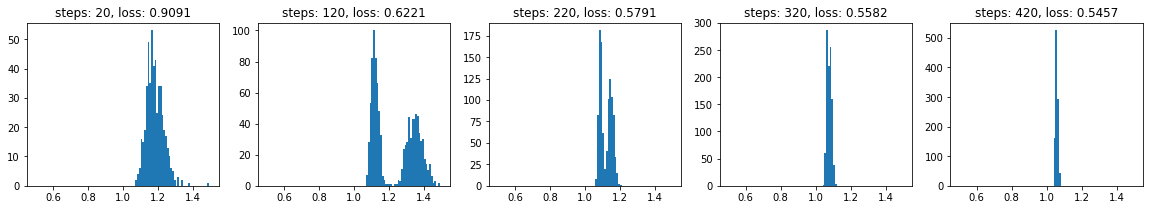

In [101]:
plot_index = [0, 5, 10, 15, 20]
figure, axes = plt.subplots(ncols=5, figsize=(20, 3))
for i,ax in enumerate(axes):
    _ = ax.hist(weights_list[plot_index[i]], bins=100, range=(0.5, 1.5))
    title = "steps: " + str((plot_index[i]+1)*report_every) + ", loss: " + str(loss_list[plot_index[i]])[:6]
    ax.set_title(title)

In [102]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)
if clf.score(X,y) == 1:
    margin = np.abs(clf.decision_function(X))

Text(0,0.5,'correlation')

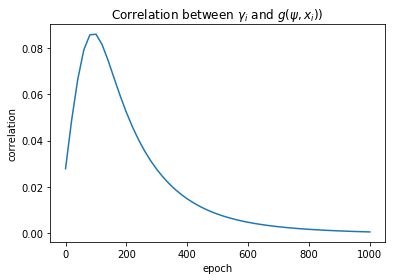

In [105]:
margin_weight_corr = [np.corrcoef(weights, margin)[0,1] for weights in weights_list]
plot_epochs = [report_every * i for i in range(len(margin_weight_corr))]
plt.plot(plot_epochs, margin_weight_corr)
plt.title(r"Correlation between $\gamma_i$ and $g(\psi, x_i)$)")
plt.xlabel("epoch")
plt.ylabel("correlation")

# Nonlinear model

In [127]:
X, y = simulation.non_lin_moon(0.05)
X = np.array(X)
y = np.array(y) * 1.0

In [128]:
random.seed(1234)
np.random.seed(234)
tf.random.set_seed(345)

tf.keras.backend.clear_session()

inputs = keras.Input(shape=2)
reg1 = keras.layers.Dense(units=5, activation = 'relu')
reg11 = keras.layers.Dense(units=1)
reg2 = keras.layers.Dense(units=1)
output1 = reg11(reg1(inputs))
output2 = reg2(inputs)
output2 = tf.exp(output2) / (1 + tf.exp(output2)) + 1

model = keras.Model(inputs=inputs, outputs=tf.concat([output1, output2], axis=-1))
model.compile(loss = weighted_loss,
             optimizer = keras.optimizers.SGD(0.1),
             metrics=["accuracy"])


In [129]:
report_every = 20
num_epochs = 2000

epoch = 0
nl_weights_list, nl_loss_list, nl_accuracy_list = [], [], []
while epoch <= num_epochs:
    model.fit(X, y, batch_size = X.shape[0], epochs = report_every, verbose=0)
    res = model(X).numpy()
    nl_weights_list.append(res[:,1])
    loss_acc = model.evaluate(X,y, verbose=0)
    nl_loss_list.append(loss_acc[0])
    nl_accuracy_list.append(loss_acc[1])
    epoch += report_every


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



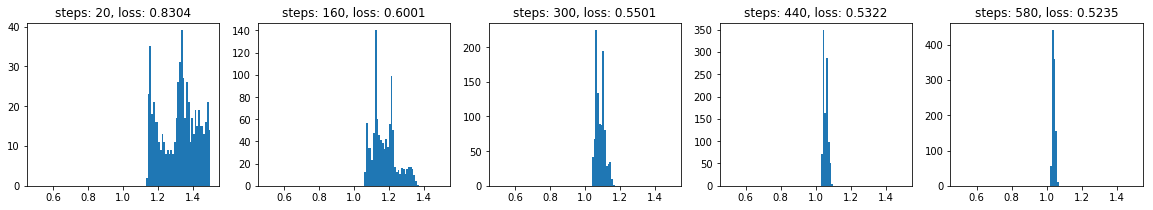

In [130]:
plot_index = [0, 7, 14, 21, 28]
figure, axes = plt.subplots(ncols=5, figsize=(20, 3))
for i,ax in enumerate(axes):
    _ = ax.hist(nl_weights_list[plot_index[i]], bins=100, range=(0.5, 1.5))
    title = "steps: " + str((plot_index[i]+1)*report_every) + ", loss: " + str(nl_loss_list[plot_index[i]])[:6]
    ax.set_title(title)

In [131]:
margin = np.abs(model.predict(X)[:,0])

(0.44, 0.455)

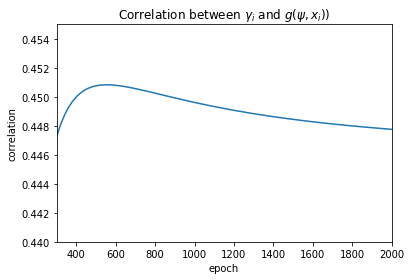

In [139]:
nl_margin_weight_corr = [np.corrcoef(weights, margin)[0,1] for weights in nl_weights_list]
plot_epochs = [report_every * i for i in range(len(nl_margin_weight_corr))]
plt.plot(plot_epochs, nl_margin_weight_corr)
plt.title(r"Correlation between $\gamma_i$ and $g(\psi, x_i)$)")
plt.xlabel("epoch")
plt.ylabel("correlation")
plt.xlim([300, 2000])
plt.ylim([0.44, 0.455])